# Assignment 1 (part I): Line Fitting and other "stuff"

## Problem 1
### Prove that any roto-reflective transformation $R^n \rightarrow R^n$ defined by $n\times n$ orthogonal matrix $R$ (s.t. $R^TR=I$) preserves (a) parallel lines and (d) distances between points. Your proof should use only linear algebraic equations. HINTS: you can use line equations of the following format: $p_t=p_o + t\,u$ where $p$ are n-vectors representing points on a line, $u$ is a vector defining the line's direction, and $t$ is a scalar parameter. For distances $d(a,b)$ between points $a,b\in R^n$ you can use $d^2(a,b)=(a-b)^T (a-b)$. NOTE that all your linear algebraic equations in the proof should work for arbitrary $n\times n$ roto-reflective transformations/matrices.

Solution:

(a) Let $l=l_0+au_l$ and $p=p_0+bu_p$ where $l$ and $p$ and parallel lines. Hence the vectors representing the lines directions can be represented as $u_l=xu_p$ where $x$ is a constant, $x\in\R^2$. Then,

$
p^\prime = Rp = Rp_0+bRu_p \\
\\
l^\prime = Rl = Rl_0+aRu_l \\
l^\prime = Rl_0+aR(xu_p) \\
l^\prime = Rl_0+axRu_p 
$

Let $c = ax$, then

$
l^\prime = Rl_0+cRu_p
$

which shows that the two lines, and thus roto-reflective matrices preserve parallelism.

(b) Let $a, b \in \R^n$ which satisfies $\\ d^2(a,b)=(a-b)^T(a-b)\\$
Let $a^\prime=Ra$ and $b^\prime=Rb$. Then,
$
d^2(a^\prime,b^\prime) = (Ra-Rb)^T(Ra-Rb) \\
= (R(a-b))^TR(a-b) \\
= (a-b)^TR^TR(a-b) \\
= (a-b)^TI(a-b) \\
= (a-b)^T(a-b) \\
= d^2(a, b)
$

Therefore the roto-reflective matrix $R$ preserves distances between points

## Problem 2
### Prove that affine transformations  $R^2 \rightarrow R^2$ map lines onto lines. For this, take an arbitrary line in $R^2$ and show that an arbitrary affine transform maps it onto a set of points that also satisfies a line equation. Use linear algebraic equations for lines, i.e. $x^Tv=c$ where $v$ is a 2-vector (normal to the line), $c$ is a scalar ($v,c$ are line parameters), and $x$ is a 2-vector corresponding to an arbitrary point on the line. Your proof should use only linear algebraic equations. 
### HINT: for inspiration, check out the argument for line presevation by homographies on slide 33, topic 4.

Solution:
An affine transformation matrix can be simplified and expressed in the form:

$
x = \begin{bmatrix} ax+by+c \\ dx+ey+f\end{bmatrix}
$

which can then be expressed in the form Ax+b. Adding that to the equation for a line, we get:

$
x^Tv=c \\
(Ax+b)^Tv=c \\
((Ax)^T + b^T)v = c \\
(x^TA^T+b^T)v=c \\
x^T(A^Tv)=(c-b^Tv) \\
x^T(D)=e
$

This shows that the affine transformation can then be expressed in the line equation given, a line is mapped onto a line.

## NOTE: Problems 3-7 below are mostly coding excersices where you should implement and/or test different standard methods for model fitting on examples with synthetic and real data. Part II of this Assignemnt requires homography estimation in a real application (panorama mosaicing). The problems below were primarily designed to help the students learn the basics of model parameter estimation in a much more basic context - simple line models and 2D data points (synthetic or real). 
### While the provided initial notebook shows synthetic and real examples of 2D data points for line fitting, you might need to restart the nootebook (Kernel->Restart and Clear Output).

## Problem 3: least-squares and line fitting in 2D (synthetic data without outliers)
### Complete implementation of function $estimate$ of class $LeastSquareLine$ in the second cell below. It should update line parameters $a$ and $b$ correpsonding to line model $y=ax+b$. You can use either SVD of matrix $A$ or inverse of matrix $A^T A$, as mentioned in class. NOTE: several cells below test your code.

In [26]:
%matplotlib inline

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from skimage.measure import ransac

#### TO IMPLEMENT: complete (fix) the code in the following cell. Note that solution has 2-3 lines. You can use $svd$ function in $la$ and/or standard matrix operations from $np$.

In [27]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, points2D: np.ndarray):
        B = points2D[:,1]
        A = np.copy(points2D)
        A[:,1] = 1.0 

        # Vector B and matrix A are already defined. Change code below
        Ainv = np.matmul(la.inv(np.matmul(A.T, A)), A.T)
        x = np.matmul(Ainv, B)
        self.a = x[0]
        self.b = x[1]
        print(f"a: {self.a} b:{self.b}")
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b

#### Working code below generates (simulates) data points in ${\cal R}^2$ corresponding to noisy observations of a line.

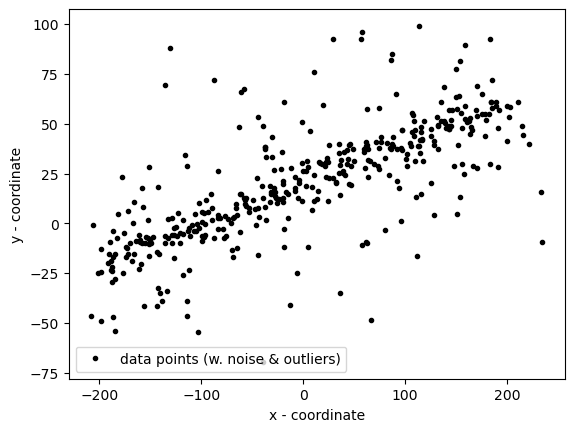

In [28]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate "idealized" line points
x = np.arange(x_start,x_end)
y = a * x + b               
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add gaussian pertubations to generate "realistic" data points (noisy line observations)
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 5 * noise
data[::2] += 10 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

# IMPORTANT COMMENT!!!!!!!: 
# the data now combines line points with different levels of additive Gaussie noise.
# Consider all these points as noisy inliers.
# Do not consider any of these as outliers. The outliers are added in Problem 4.


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

#### Use the following code-cell to test your implementation of class $LeastSquareLine$ in Problem 3 for line fitting when observed data is noisy. The estimated line is displayed in the cell above.  Note that the initial result shown in Fig.1 of the provided notebook corresponds to the line $a=0,b=0$ returned by initial code for $LeastSquareLine$.  Your correct solution for $LeastSquareLine$ should return a line very close to the known (ground-truth) line model.

a: 0.18353493312620203 b:19.956828768346007
True


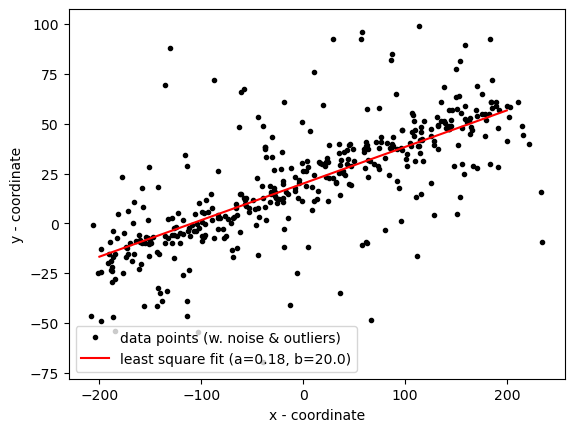

In [29]:
LSline = LeastSquareLine() # uses class implemented in Problem 2
print(LSline.estimate(data))
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

## Problem 4: RANSAC for robust line fitting in 2D (synthetic data with outliers)

#### Working code in the cell below corrupts data with outliers.

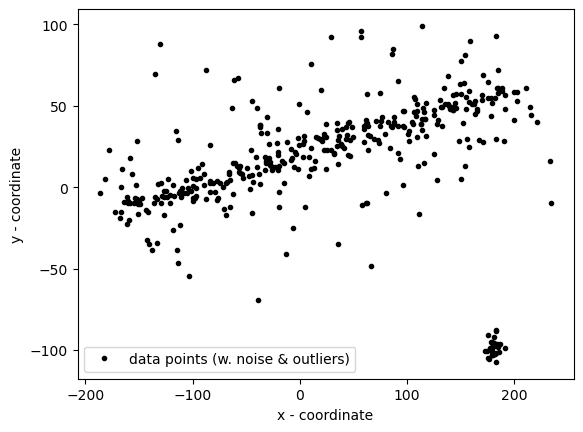

In [30]:
# add outliers
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

### NOTE: As clear from the code for data simulation, (creation of) outliers has nothing to do with the line. In contrast, all other points originate from some points on the true (perfect) line, see Probelm 3. The added Gaussian errors (large or small) simulate complex noise that commonly happens between true (but unknown) model and its real observations (data). The whole point of "model fitting" is to estimate (or restore) a "model" (e.g. line parameters) from its noisy observations (data). If data has no noise, it is trivial, e.g. only two line points would be enough to compute the line parameters exactly. In the presence of noise, one can use methods like least-squres to approximately estimate a line (parameters minimizing the loss functing summing squared $L_2$ errors), see Problem 3. However, if data is corrupted by outliers that have nothing to do with the model, as in Problem 4, more robust model fitting methods are needed, e.g. RANSAC.

#### The code below uses your implementation of class $LeastSquareLine$ from Probelm 3 for least-square line fitting when the data is corrupted with outliers. The estimated line is displayed in the cell above. Observe the differences with the result in Problem 3.

a: 0.03838661991009083 b:13.241985265558943
True


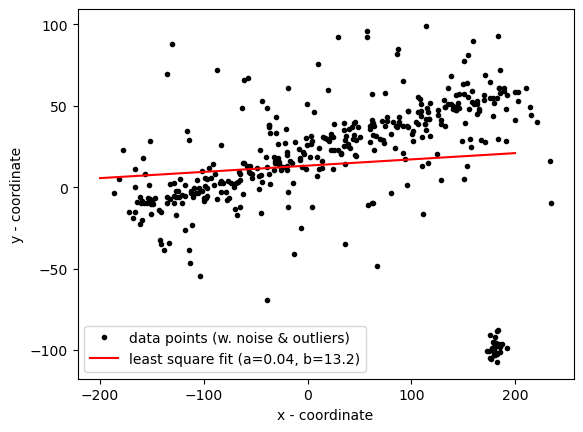

In [31]:
LSline = LeastSquareLine() # uses class implemented in Problem 2
print (LSline.estimate(data))
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

### (part a) Assume that a set of $N=100$ points in $2D$ includes $N_i=20$ inliers for one line and $N_o=80$ outliers. What is the least number of times one should sample a random pair of points from the set to get probability $p\geq 0.95$ that in at least one of the sampled pairs both points are inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution: Let $X$ represent the minimum number of times one should sample s.t. pairs of points are inliers. First, we find the probability of an outlier being found, $1-\frac{N_o}{N}$. Then, for it to be found 2 times in a row, the expression is squared. Now we check the probability of one or more of the sample is an outlier using 1-(expression above). Then we use the power of X for the number of samples. Now we are yielding the probability of there being a set which fulfills only the contaminated sets. To fulfill the number of inliers, we use 1-(previous expression). The following equation is:

$
0.95 \geq 1-(1-(1-\frac{N_o}{N})^2)^X \\
X \geq \frac{\ln(0.05)}{\ln(1-(1-\frac{N_o}{N})^2)} \\
X \geq \frac{\ln(0.05)}{\ln(1-(1-\frac{80}{100})^2)} = 73.38 \\
X = 74
$

Source: https://www.cse.psu.edu/~rtc12/CSE486/lecture15.pdf

### (part b) Using the knowledge of the number of inliers/outliers in the example at the beginning of Problem 4, estimate the minimum number of sampled pairs needed to get RANSAC to "succeed" (to get at least one pair of inliers) with $p\geq 0.95$. Use your formula in part (a). Show your numbers in the cell below. Then, use your estimate as a value of parameter $max\text{}trials$  inside function $ransac$ in the code cell below and test it.  You should also change $residual\text{}threshold$ according to the noise level for inliers in the example. NOTE: the result is displayed in the same figure at the beginning of Problem 4.

Your estimates: 
Given there are 30 outliers per the start of Q4, and a total of 400 points. Changing the 2 to 4 for the number of subsequent points checked to be inliers, using the same derivation above, the following equation is obtained:

$
0.95 \geq 1-(1-(1-\frac{N_o}{N})^4)^X \\
X \geq \frac{\ln(0.05)}{\ln(1-(1-\frac{N_o}{N})^4)} \\
X \geq \frac{\ln(0.05)}{\ln(1-(1-\frac{30}{400})^4)} = 2.27 \\
X = 3
$

a: 0.09478969564029349 b:35.61384513932994
a: 0.20938487789195806 b:19.558581449150495
a: 0.21240258148176705 b:18.503359773755612
a: 0.20373728851393658 b:20.270575500049695


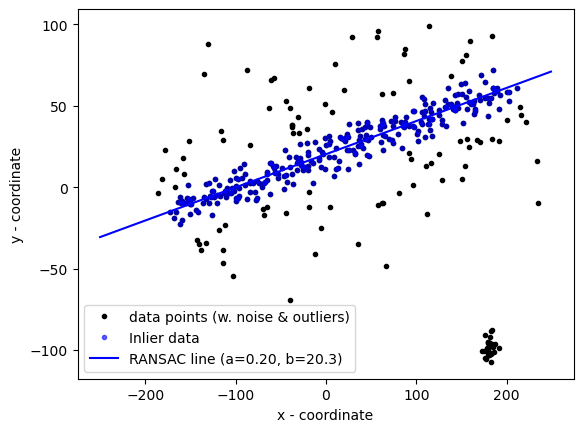

In [32]:
# robustly fit line using RANSAC algorithm
model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=15, max_trials=3)
a_rs, b_rs = model_robust.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust.predict_y(line_x)

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

## Problem 5: sequential RANSAC for robust multi-line fitting (synthetic data)

#### Adding data points supporting one more line

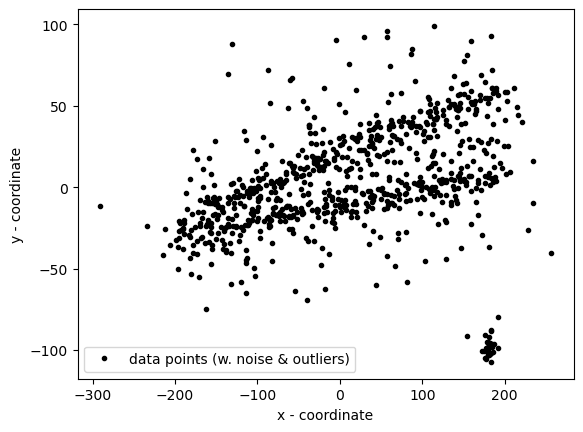

In [33]:
# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate "idealized" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add gaussian pertubations to generate "realistic" line data
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 5 * noise
data2[::2] += 10 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

data = np.concatenate((data,data2)) # combining with previous data

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

### Write code below using sequential RANSAC to detect two lines in the data above. Your lines should be displayed in the figure above (in Problem 5).

a: -0.056000168232809386 b:19.295358587276688
a: 0.41808710442881425 b:16.64123722536919
a: 1.4872683081112597 b:-157.72819550407044
a: -0.05832979621279022 b:6.086658544416737
a: 0.004696588100527643 b:-6.902488014308725
a: 0.0011444510941818198 b:60.67644091707629
a: 0.17979492426649102 b:-8.184585822977883
a: 0.18258997502930663 b:10.785310996286322
a: -0.4466393725416804 b:-21.376602145165975
a: 0.06935606245307041 b:-15.449111504832594
a: -0.07487091829447617 b:-21.510013101405526
a: 0.04159861934835481 b:3.1375577727510984
a: 0.8740125401905311 b:-104.66882967287839
a: 0.447619721153003 b:-22.514367299679336
a: 0.25336136431731804 b:19.268711078828403
a: 0.24149615079364312 b:18.870972960296477
a: 0.439607677440336 b:-50.67783018970289
a: 3.2827266776770077 b:-686.5477582022369
a: 0.23786765213234123 b:4.976789208786636
a: 0.2004633318742557 b:-0.40206634955908527
a: -0.7988169629990803 b:44.49740126891782
a: -0.5663946522433889 b:7.2063534026207225
a: -0.4094755125892011 b:41.00

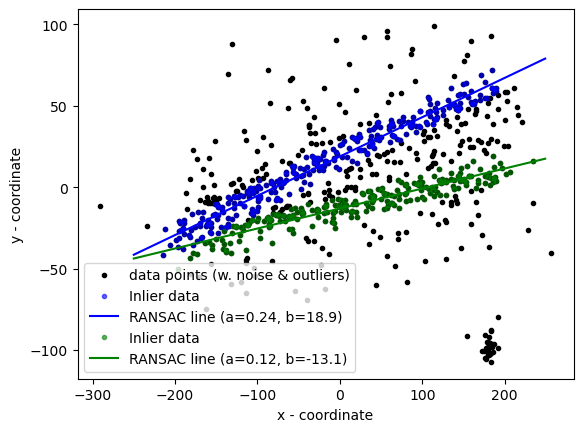

In [34]:
# robustly fit line using RANSAC algorithm
model_robust_1, inliers_1 = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=10, max_trials=15)
a_rs, b_rs = model_robust_1.line_par()

new_data = data[~inliers_1]
model_robust_2, inliers_2 = ransac(new_data, LeastSquareLine, min_samples=2, residual_threshold=10, max_trials=15)
a_rs_2, b_rs_2 = model_robust_2.line_par()

line1_x = np.arange(-250, 250)
line1_y_robust = model_robust_1.predict_y(line1_x)

line2_x = np.arange(-250, 250)
line2_y_robust = model_robust_2.predict_y(line2_x)

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
ax.plot(data[inliers_1, 0], data[inliers_1, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line1_x, line1_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.plot(new_data[inliers_2, 0], new_data[inliers_2, 1], '.g', alpha=0.6, label='Inlier data')
ax.plot(line2_x, line2_y_robust, '-g', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs_2,b_rs_2))
ax.legend(loc='lower left')
plt.show()


## Problem 6: multi-line fitting for real data (Canny edges)
### NOTE: while there are real applications that require estimation of lines in images, their detailed description is outside the scope of this assignment. This problem is mostly for fun. However, it also demostrates a real example of simple 2D feature points (based on contrast edges) that can be used for estimating real geometric models (lines). More advanced real examples of feature points and geometric model estimation can be found in part II of this Assignment.

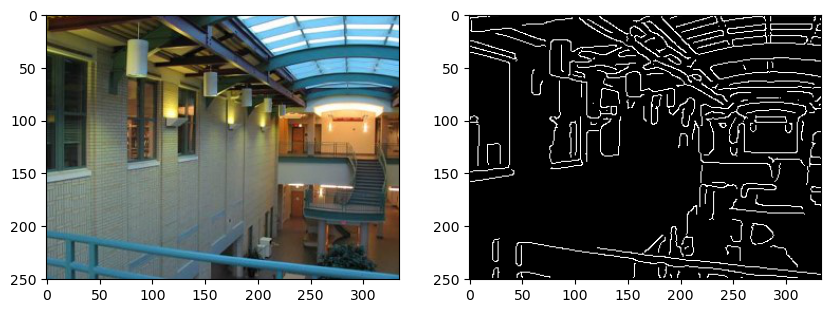

In [35]:
import matplotlib.image as image
from skimage import feature
from skimage.color import rgb2gray

im = image.imread("images/CMU_left.jpg")
imgray = rgb2gray(im)
can = feature.canny(imgray, 2.0)

plt.figure(4,figsize = (10, 4))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(can,cmap="gray")
plt.show()

## use sequestial-RANSAC to find  𝐾  lines

a: -0.015748031496063186 b:152.61417322834643
a: -15.727272727274725 b:4606.36363636418
a: 0.16299559471365643 b:87.8854625550661
a: 0.7435897435897452 b:-152.5897435897441
a: 0.1985294117647054 b:121.52941176470593
a: 1.8347826086956516 b:-190.1739130434783
a: 0.4171779141104296 b:-10.582822085889546
a: 1.4807692307692306 b:-123.82692307692314
a: 1.250000000000001 b:-154.00000000000037
a: 1.438596491228069 b:-159.92982456140322
a: -0.7355371900826442 b:316.88429752066116
a: -0.6739130434782772 b:302.15217391304543
a: 0.15789473684210975 b:123.99999999999989
a: -1.3575757575757577 b:315.95151515151514
a: 0.11627906976744296 b:59.511627906976884
a: -1.5703125 b:275.3984375
a: -1.3606557377049082 b:490.55737704917857
a: 0.047297297297297924 b:73.75000000000006
a: 0.8999999999999986 b:-182.09999999999877
a: -0.5657894736842117 b:177.14473684210526
a: 1.3134328358208944 b:-296.2835820895518
a: 0.04444444444444445 b:48.31111111111111
a: 0.08823529411764675 b:209.26470588235134
a: -0.6075949

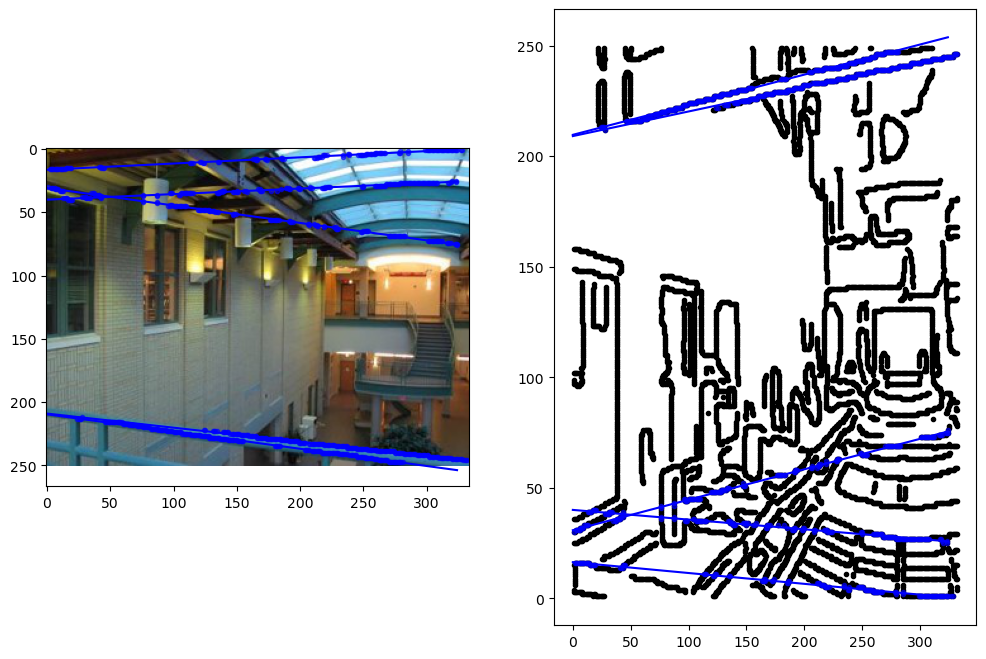

In [36]:

K = 5 
# NOTE 1: write your code using a function that takes K as a parameter. 
# NOTE 2: Present visual results for some value of K 
# NOTE 3: Your code should visually show detected lines in a figure 
#         over the image (either the original one or over the Canny edge mask)
# NOTE 4: You may need to play with parameters of function ransac 
#         (e.g. threshold and number of sampled models "max_trials")
#         Also, you can introduce one extra parameter for the minimum number of inliers 
#         for accepting ransac-detected lines.

# NOTE: "can" in the cell above is a binary mask with True and False values, e.g. 

edges = np.argwhere(can)[:, [1,0]]
data_vals = []
model_robust_vals = []
inliers_vals = []
a_vals = []
b_vals = []
line_x_vals = []
line_y_vals = []

data_vals.append(edges)

for _ in range(K):
    data = data_vals[-1]
    model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=1, max_trials=100)
    a, b = model_robust.line_par()

    line_x = np.arange(0, 325)
    line_y_robust = model_robust.predict_y(line_x)

    data_vals.append(data[~inliers])
    inliers_vals.append(inliers)
    a_vals.append(a)
    b_vals.append(b)
    line_x_vals.append(line_x)
    line_y_vals.append(line_y_robust)

plt.figure(6, figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(im)
for i in range(K):
    plt.plot(data_vals[i][inliers_vals[i], 0], data_vals[i][inliers_vals[i], 1], '.b', alpha=0.6, label=f'Inlier data {i}')
    plt.plot(line_x_vals[i], line_y_vals[i], '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_vals[i], b_vals[i]))

plt.subplot(1, 2, 2)
plt.plot(edges[:, 0], edges[:, 1], '.k')
for i in range(K):
    plt.plot(data_vals[i][inliers_vals[i], 0], data_vals[i][inliers_vals[i], 1], '.b', alpha=0.6, label=f'Inlier data {i}')
    plt.plot(line_x_vals[i], line_y_vals[i], '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_vals[i], b_vals[i]))
